In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import tensorflow as tf

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [41]:
# parameters
lr = 0.001
epochs = 40000
batch_size = 64
disp_step = 1000
examples_to_show = 10

In [14]:
# PARAMETERS 
num_in = 784
hidd = 512
latent = 2

# i/o
X = tf.placeholder(tf.float32, [None, num_in])

# A custom initialization (see Xavier Glorot init)
def glorot_init(shape):
    return tf.random_normal(shape=shape, stddev=1. / tf.sqrt(shape[0] / 2.))


# weights as dictionaries
weights = {
    'encoder_w1': tf.Variable(glorot_init([num_in, hidd])),
    'encoder_b1': tf.Variable(glorot_init([hidd])),
    'z_mean_w2': tf.Variable(glorot_init([hidd, latent])),
    'z_mean_b2': tf.Variable(glorot_init([latent])),
    'z_std_w2': tf.Variable(glorot_init([hidd, latent])),
    'z_std_b2': tf.Variable(glorot_init([latent])),
    #
    'decoder_w1': tf.Variable(glorot_init([latent, hidd])),
    'decoder_b1': tf.Variable(glorot_init([hidd])),
    'decoder_w2': tf.Variable(glorot_init([hidd, num_in])),
    'decoder_b2': tf.Variable(glorot_init([num_in])),
}

In [38]:
# DEFINE MODEL wrappers

def encoder(x):
    lay1 = tf.nn.tanh(tf.add(tf.matmul(x, weights['encoder_w1']), weights['encoder_b1']))
    latent_mean = tf.add(tf.matmul(lay1, weights['z_mean_w2']), weights['z_mean_b2'])
    latent_std = tf.add(tf.matmul(lay1, weights['z_std_w2']), weights['z_std_b2'])
    # sample from mean and std
    # noise
    eps = tf.random_normal(tf.shape(latent_std), dtype=tf.float32, mean=0., stddev=1.0, name='epsilon')
    # sample
    z = latent_mean + tf.exp(latent_std / 2) * eps
        
    return z, latent_mean, latent_std
    

def decoder(z):
    lay1 = tf.nn.tanh(tf.add(tf.matmul(z, weights['decoder_w1']), weights['decoder_b1']))
    lay2 = tf.nn.sigmoid(tf.add(tf.matmul(lay1, weights['decoder_w2']), weights['decoder_b2']))
    return lay2


In [17]:
encoder_op, latent_mean, latent_std = encoder(X)
decoder_op = decoder(encoder_op)

In [28]:
# COST
def VAE_loss(x_reconstructed, x_true):
    # reconstruction loss
    ED_loss = x_true * tf.log(1e-10 + x_reconstructed) + \
               (1 - x_true) * tf.log(1e-10 + 1 - x_reconstructed)
    ED_loss = -tf.reduce_sum(ED_loss, 1)
    
    # KL-divergence loss
    KL_loss = 1 + latent_std - tf.square(latent_mean) - tf.exp(latent_std)
    KL_loss = -0.5 * tf.reduce_sum(KL_loss, 1)
    
    return tf.reduce_mean(ED_loss + KL_loss)


In [29]:
# EVALUATION
y_pred = decoder_op
y_true = X

op_cost = VAE_loss(y_pred, y_true)

In [30]:
# OPTIMISATION
op_optimizer = tf.train.RMSPropOptimizer(learning_rate=lr).minimize(op_cost)


In [42]:
# INIT
init = tf.global_variables_initializer()

In [43]:
###  TRAINING SESSION
s = tf.Session()
s.run(init)

for i in range(epochs):
    batch_xs, _ = mnist.train.next_batch(batch_size)
    # Run optimization op (backprop) and cost op (to get loss value)
    _, l = s.run([op_optimizer, op_cost], feed_dict={X: batch_xs})
    # Display logs per step
    if i % disp_step == 0 or i == 1:
        print('Step %i: Minibatch Loss: %f' % (i, l))
    

Step 0: Minibatch Loss: 634.803528
Step 1: Minibatch Loss: 622.045410
Step 1000: Minibatch Loss: 183.733810
Step 2000: Minibatch Loss: 156.612305
Step 3000: Minibatch Loss: 167.449432
Step 4000: Minibatch Loss: 172.478668
Step 5000: Minibatch Loss: 165.519440
Step 6000: Minibatch Loss: 164.559021
Step 7000: Minibatch Loss: 143.277222
Step 8000: Minibatch Loss: 157.722610
Step 9000: Minibatch Loss: 156.283310
Step 10000: Minibatch Loss: 159.735107
Step 11000: Minibatch Loss: 154.104309
Step 12000: Minibatch Loss: 156.191833
Step 13000: Minibatch Loss: 163.055176
Step 14000: Minibatch Loss: 151.311798
Step 15000: Minibatch Loss: 156.017975
Step 16000: Minibatch Loss: 154.714813
Step 17000: Minibatch Loss: 159.420471
Step 18000: Minibatch Loss: 144.798325
Step 19000: Minibatch Loss: 149.910904
Step 20000: Minibatch Loss: 151.622223
Step 21000: Minibatch Loss: 153.398773
Step 22000: Minibatch Loss: 149.799133
Step 23000: Minibatch Loss: 159.437347
Step 24000: Minibatch Loss: 135.506561
Ste

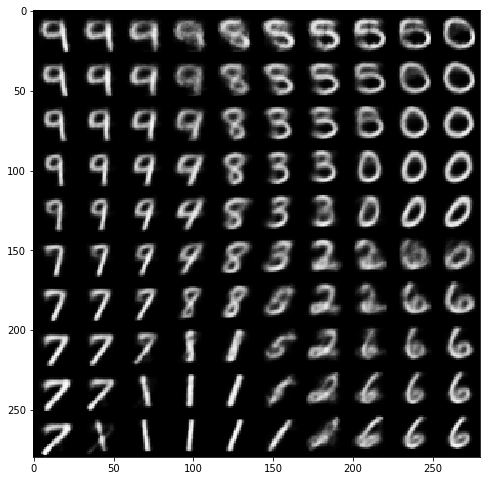

In [44]:
###  TESTING SESSION

# Encode and decode images from test set and visualize their reconstruction.
n = examples_to_show
x_axis = np.linspace(-3, 3, n)
y_axis = np.linspace(-3, 3, n)

canvas = np.empty((28 * n, 28 * n))
for i, yi in enumerate(x_axis):
    for j, xi in enumerate(y_axis):
        z_mu = np.array([[xi, yi]] * batch_size) 
#         x_mean = s.run(decoder_op, feed_dict={noise_input: z_mu})
        x_mean = decoder(tf.cast(z_mu, tf.float32))
        image = s.run(x_mean)
#         print image.shape
        canvas[(n - i - 1) * 28:(n - i) * 28, j * 28:(j + 1) * 28] = \
        image[0].reshape(28, 28)

plt.figure(figsize=(8, 10))
Xi, Yi = np.meshgrid(x_axis, y_axis)
plt.imshow(canvas, origin="upper", cmap="gray")
plt.show()


###################################
# # Testing
# # Generator takes noise as input
# noise_input = tf.placeholder(tf.float32, shape=[None, latent])
# # Rebuild the decoder to create image from noise
# decoder = tf.matmul(noise_input, weights['decoder_w1']) + weights['decoder_b1']
# decoder = tf.nn.tanh(decoder)
# decoder = tf.matmul(decoder, weights['decoder_w2']) + weights['decoder_b2']
# decoder = tf.nn.sigmoid(decoder)

# # Building a manifold of generated digits
# n = 20
# x_axis = np.linspace(-3, 3, n)
# y_axis = np.linspace(-3, 3, n)

# canvas = np.empty((28 * n, 28 * n))
# for i, yi in enumerate(x_axis):
#     for j, xi in enumerate(y_axis):
#         z_mu = np.array([[xi, yi]] * batch_size)
#         x_mean = s.run(decoder, feed_dict={noise_input: z_mu})
#         canvas[(n - i - 1) * 28:(n - i) * 28, j * 28:(j + 1) * 28] = \
#         x_mean[0].reshape(28, 28)

# plt.figure(figsize=(8, 10))
# Xi, Yi = np.meshgrid(x_axis, y_axis)
# plt.imshow(canvas, origin="upper", cmap="gray")
# plt.show()

